In [1]:
using PyPlot
using LinearAlgebra, Statistics, Random #(built-in)

## Code for Figure 1

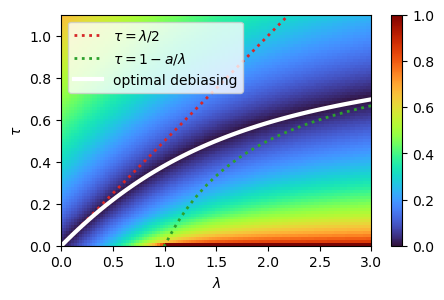

sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


PyObject <matplotlib.legend.Legend object at 0x7ff2b19fefd0>

In [2]:
figure(figsize=[5,3])
ls = range(0.0,3,length=120)
ts = range(0.0,1.4,length=100)
 
f_true(a,l,t) = ((a+sqrt((a-l)^2+4a*t))^2-l^2)/(4a)
pcolor(ls,ts,abs.(sqrt.(f_true.(1.0,ls',ts)) .- 1.0).^(2/2),cmap="turbo")
xlabel(L"\lambda")
ylabel(L"\tau")
plot(ls,ls/2,":C3",lw=2,label=L"\tau=\lambda/2")
plot(ls,max.(1 .- 1 ./ls, -0.01),":C2",lw=2,label=L"\tau=1 - a/\lambda")
 
plot(ls,ls/2 .+ (1 .- sqrt.(1 .+ ls.^2 ./4)),"w",lw=3,label="optimal debiasing")
colorbar()
axis([0,3,0,1.1])
legend(loc=2)
#savefig("optimal-debiasing.png",bbox_inches="tight",dpi=200)

## Code for figure 2

Here we fix a grid on size $m$ on the interval $[0,1]$ and compute barycenters of densities.

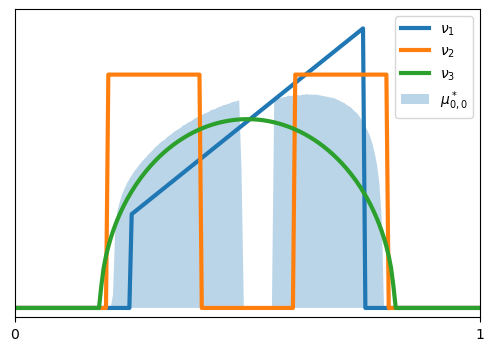

In [286]:
m = 200
xs = range(0,1,length=m)
q1 = xs.* [(y>0.25) && (y<0.75) for y in xs]
q1 = q1 / sum(q1)
q2 = [(y>0.2) && (y<0.4) || (y>0.6) && (y<0.8) for y in xs]
q2 = q2 / sum(q2)
q3 = sqrt.(max.(0.1 .- (xs .- 0.5).^2,0))
q3 = q3 / sum(q3)
ref = ones(m)/m;
qs = cat(q1,q2,q3,dims=2);

figure(figsize=[6,4])
fill_between(xs,bb,alpha=0.3,label=L"\mu^*_{0,0}")
plot(xs,q1,lw=3,label=L"\nu_1")
plot(xs,q2,lw=3,label=L"\nu_2")
plot(xs,q3,lw=3,label=L"\nu_3")
#plot(xs,p4,":k",alpha=0.4,label=L"\mu^*_{\lambda,\mathrm{div}}") # should be computer with different params.
legend()
yticks([])
xticks([0,1])
axis([0,1,-0.0005,0.016])
#savefig("bary1D-marg.png",bbox_inches="tight",dpi=200)

In [405]:
"(lambda,tau)-barycenter on [0,1] via gradient ascent on the dual"
function bary1D(qs, ws, ref, λ, τ, niter, η, tol)
    (m,k) = size(qs)
    xs = range(0,1,length=m)
    C = [(x-y)^2/2 for x in xs, y in xs] # m x n
    vs = zeros(m,k)
    us = zeros(m,k)
    val = zeros(niter)
    err = zeros(niter)
    grad = zeros(m,k)
    p = zeros(m)
    xi = 0
    for kk=1:niter
        for i=1:k
            us[:,i] = us[:,i] - λ * log.( sum(exp.( (vs[:,i] .+ us[:,i]' .- C' )/λ).*qs[:,i], dims = 1))[:]
        end
        V = sum(ws' .* us, dims=2)
        xi = xi - τ*log(sum(exp.((xi .- V) /τ).*ref)) #to stabilize computations
        p = exp.( (xi .- V)/τ).*ref
        val[kk] = sum(ws'.*vs.*qs) - τ*log(sum(exp.(-V/τ).*ref))
        for i=1:k
            gam = exp.((xi .- V)/τ .+ (us[:,i] .+ vs[:,i]' .- C)/λ) .* ref
            grad[:,i] = ones(n) - sum(gam, dims=1)[:]
        end
        err[kk]=sum( ws[i]*sum(abs.(grad[:,i].*qs[:,i])) for i=1:k)
        vs = vs .+ η * grad
        if err[kk]<tol
            val = val[1:kk]
            break
        end
        if k==niter
            print("didn't converge")
        end
    end
    return p, val, err
end

bary1D

In [147]:
"Sinkhorn divergence barycenter via algorithm 1 in Janati & Cuturi (Debiaised Sinkhorn barycenter)"
function SDbary1D(qs,ws,ref,λ,niter)
    
    (m,k) = size(qs)
    xs = range(0,1,length=m)
    C = [(x-y)^2/2 for x in xs, y in xs] # m x n
    K = exp.(- C/λ)
    a = ones(m,k)
    b = ones(m,k)
    d = ones(m)
    alpha = ones(m)
    for kk = 1:niter
        for i=1:k
            a[:,i] = qs[:,i]./(K*b[:,i])
        end
        alpha = d 
        for i=1:k
            alpha = alpha .* (K'*a[:,i]).^(ws[i])
        end
        for i=1:k
            b[:,i] = alpha ./ (K'*a[:,i])
        end
        for j=1:10 #sub-loop to make sure the alg. converges
            d = sqrt.(d .* (alpha ./ (K*d)))
        end
    end
    return alpha
end

SDbary1D (generic function with 1 method)

In [244]:
"1D Wasserstein exact barycenter via averging the quantile functions"
function Wbary1D(qs,ws)
    # (this is a quick *very* dirty implementation: use *very* fine discretizations to get accurate results)
    m,k = size(qs)
    xs = range(0,1,length=m)
    Cs = cumsum(qs,dims=1)
    Qs = zeros(m,k) # quantile functions
    for i=1:k
        for j=1:m #use xs as a discretization as well
            ind = findfirst(Cs[:,i] .> xs[j] .- 1e-4)
            Qs[j,i] = (ind-1) / (m-1)
        end
    end
    Qbary = sum(Qs .* ws', dims=2)[:] # quantile function of the barycenter
    Cb = zeros(m) # invert it to recover the cdf of barycenter
        for j=1:m #use xs as a discretization as well
            ind = findfirst(Qbary .> xs[j] )
            if ind == nothing 
                ind = m
            end
            Cb[j] = (ind-1) / (m-1)
        end
    pdf = (Cb[2:end] .- Cb[1:end-1])/m
    b = [sum(pdf[k:k+199]/200) for k=1:m-200]
    b = b ./ sum(b)
    return b
end

Wbary1D

Compare convergence speed

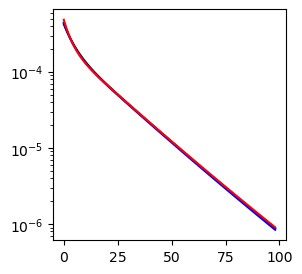

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff2501078b0>

In [410]:
λ = 1/256
niter = 500
#tol = 1e-5
η = 0.001
qs = cat(q1,q2,q3,dims=2)
ws = ones(3)/3
p1, val1, err1 = bary1D(qs, ws, ref, λ, λ, niter,η, tol);
p2, val2, err2 = bary1D(qs, ws, ref, λ, λ/2, niter,η, tol);
p3, val3, err3 = bary1D(qs, ws, ref, λ, λ/4, niter,η, tol);
niter = 5000
p4 = SDbary1D(qs, ws, ref, λ, niter); #quite slow convergence...
figure(figsize=[3,3])
semilogy(val1[end] .- val1[2:100],"k")
semilogy(val2[end] .- val2[2:100],"b")
semilogy(val3[end] .- val3[2:100],"r")

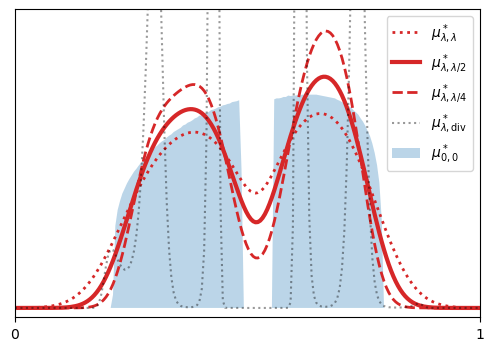

(0.0, 1.0, -0.0005, 0.016)

In [411]:
figure(figsize=[6,4])
fill_between(xs,bb,alpha=0.3,label=L"\mu^*_{0,0}")
plot(xs,p1,lw=2,":C3",label=L"\mu^*_{\lambda,\lambda}")
plot(xs,p2,lw=3,"C3",label=L"\mu^*_{\lambda,\lambda/2}")
plot(xs,p3,lw=2,"--C3",label=L"\mu^*_{\lambda,\lambda/4}")
plot(xs,p4,":k",alpha=0.4,label=L"\mu^*_{\lambda,\mathrm{div}}")
legend()
yticks([])
xticks([0,1])
axis([0,1,-0.0005,0.016])
#savefig("bary1D-128.png",bbox_inches="tight",dpi=200)

# Noisy Particle Gradient Descent

In [2]:
include("sinkhorn-acceleration.jl")
# this is an accelerated version of Sinkhorn's algorithm (with RNA, see https://arxiv.org/abs/1711.01851)

sinkhorn_RNA

In [104]:
m = 200 # nb of particles (should be even here)
n = 2   # nb of samples in marginals
d = 2   # dimension
p = 2   # nk of marginals
niter = 400
lr = 0.5 # step size
lambda = 0.1

Y = zeros(d,n,p) # marginals of the measures of which we take the barycenter (positions)
b = ones(n,p) ./ n #  (weights)

# Define the two marginals
Y[:,:,1] = cat([-3;0],[-1; 1], dims=2)
Y[:,:,2] = cat([3;0],[1; 1], dims=2)
#Y[:,:,3] = randn(d,n) ./2 .+ 2*cat(ones(1,n), zeros(1,n), dims=1)

X = zeros(d,m,niter) # particles of the barycenter
a = ones(m) ./ m
X[:,:,1] = cat(repeat([0;0], outer=(1, div(m,2))),repeat([0;1], outer=(1, div(m,2))), dims=2) # start from a saddle point
grad = zeros(d,m,p)

@time for t = 1:niter-1
    for k = 1:p
        C = [sum((X[:,i,t] - Y[:,j,k]).^2)/2 for i=1:m, j=1:n ] # compute cost matrix
        u, v, errs = sinkhorn_RNA(a, b[:,k], C, lambda, RNA_order=4);
        g = exp.((u .+ v' .- C)/lambda) .* a .* b[:,k]' #transport plan between mu and nu_k
        for i = 1:m
            # gradient induced by nu_k (given by "barycentric projection")
            grad[:,i,k] = X[:,i,t] - sum( Y[:,j,k] * g[i,j] for j=1:n) ./ sum( g[i,j] for j=1:n)  
        end
    end
        # noisy gradient update
        X[:,:,t+1] = X[:,:,t ] - lr * sum(grad, dims = 3)/p + sqrt(lambda*lr)*randn(d,m)/2 #diffusivity is lambda/2
end

  2.644986 seconds (11.94 M allocations: 3.094 GiB, 8.56% gc time, 3.76% compilation time)


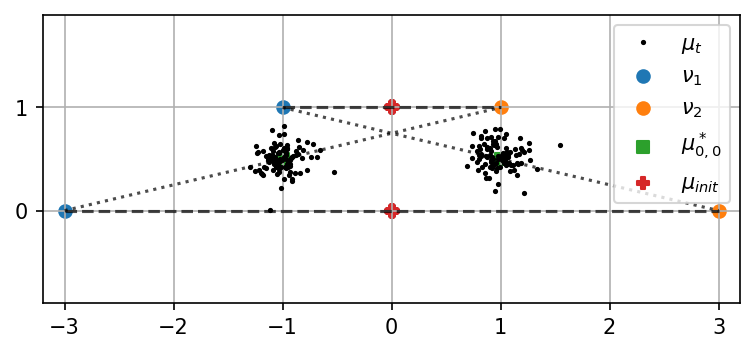

In [124]:

for t=niter#20#1:20:niter
    figure(figsize=[6,2.5],dpi=150)
    scatter(Y[1,:,1],Y[2,:,1],c="C0",label=L"\nu_1")
    scatter(Y[1,:,2],Y[2,:,2],c="C1",label=L"\nu_2")
    plot(X[1,:,t],X[2,:,t],".k",label=L"\mu_t",ms=3)
    plot([Y[1,1,1]; Y[1,1,2]],[Y[2,1,1] ;Y[2,1,2]],"--k",alpha=0.7)
    plot([Y[1,1,1]; Y[1,2,2]],[Y[2,1,1] ;Y[2,2,2]],":k",alpha=0.7)
    scatter((Y[1,1,1]+Y[1,2,2])/2,(Y[2,1,1]+Y[2,2,2])/2,c="C2",marker="s",label=L"\mu^*_{0,0}")
    plot([Y[1,2,1]; Y[1,1,2]],[Y[2,2,1] ;Y[2,1,2]],":k",alpha=0.7)
    plot([Y[1,2,1]; Y[1,2,2]],[Y[2,2,1] ;Y[2,2,2]],"--k",alpha=0.7)
    scatter((Y[1,2,1]+Y[1,1,2])/2,(Y[2,2,1]+Y[2,1,2])/2,c="C2",marker="s")
    for i=1:m
    #    plot(X[1,i,max(1,t-3):t],X[2,i,max(1,t-3):t],"k",lw=0.2)
    end
    scatter(X[1,:,1],X[2,:,1],c="C3",marker="P",label=L"\mu_{init}")
    axis([-3.2,3.2,-0.9,1.9])
    yticks([0,1])
   # axis("equal")
    legend(loc=1)
    grid("on");#axis("off")
    savefig("output/bary2D-$(t).png",bbox_inches="tight")
    #close()
end